# Online regression using a Kalman Filter for Air Quality
see also 'Optimum Linear Estimation' at https://www.sciencedirect.com/topics/social-sciences/kalman-filter

- Replaces an offline multiple linear regression (MLR) batch run, runs recursively on an Arduino Atmega1284P as adaptive filter for the MLR regression coefficients
- Kalman Filter is derived from https://github.com/zziz/kalman-filter
- For theory, please read https://en.wikipedia.org/wiki/Kalman_filter
- Key is to set the covariance of the process noise matrix to a zero matrix! See hint in 'Optimum Linear Estimation' at https://www.sciencedirect.com/topics/social-sciences/kalman-filter.
- I send a big thank you to those who provided these great basis contributions
- Click on the button 'Re-start the kernel, and then re-run the whole notebook' above

## Basic Kalman Filter class from https://github.com/zziz/kalman-filter:

In [1]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)             # Predicted (a priori) state estimate
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q      # Predicted (a priori) estimate covariance
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)                                  # Innovation or measurement pre-fit residual
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))           # Innovation (or pre-fit residual) covariance
        #print("\nUpdate: self.H = ", self.H)
        #print("\nUpdate: self.P = ", self.P)
        #print("\nUpdate: self.R = ", self.R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))          # Optimal Kalman gain
        #print("\nUpdate: Kalman gain matrix K  = ", K)
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), (I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T) # Updated (a posteriori) estimate covariance 

## Read historian.csv (same input file as 'Multiple linear regression for BME680 gas readings of a single sensor.ipynb' is using

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from datetime import datetime

import numpy as np


dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y %H:%M:%S,%f')
  
df0 = pd.read_csv("historian.csv", sep=';', thousands=".", decimal=",", skiprows = [0,1,2],dtype={'High': np.float64, 'Low': np.float64}, header = None, encoding= 'unicode_escape',  parse_dates=[0], date_parser=dateparse, names = [ 'Datum', 'Mode', 'raw_gas_resistance', 'relative_humidity', 'temperature'])

# print first 5 lines of the pandas dataframe

df0.head(19)


,Datum,Mode,raw_gas_resistance,relative_humidity,temperature
0,2021-01-15 19:00:00.000,2,177160,28.9,24.6
1,2021-01-15 19:00:56.674,2,177160,28.9,24.6
2,2021-01-15 19:00:56.683,2,177160,29.6,24.6
3,2021-01-15 19:00:56.688,2,174900,29.6,24.6
4,2021-01-15 19:05:29.488,2,174900,29.6,24.6
5,2021-01-15 19:05:29.498,2,174900,30.1,24.6
6,2021-01-15 19:05:29.504,2,175280,30.1,24.6
7,2021-01-15 19:10:02.302,2,175280,30.1,24.6
8,2021-01-15 19:10:02.306,2,175280,29.7,24.6
9,2021-01-15 19:10:02.312,2,175860,29.7,24.6


In [3]:
# keep every 3rd row (CCU historian is tracking every change of a datapoint separately)
# each three consecutive entries in history.csv are identical; therefore we take every third entry only 
df = df0[(df0.index % 3 == 0)]

df.head(7)

,Datum,Mode,raw_gas_resistance,relative_humidity,temperature
0,2021-01-15 19:00:00.000,2,177160,28.9,24.6
3,2021-01-15 19:00:56.688,2,174900,29.6,24.6
6,2021-01-15 19:05:29.504,2,175280,30.1,24.6
9,2021-01-15 19:10:02.312,2,175860,29.7,24.6
12,2021-01-15 19:14:35.120,2,173780,29.9,24.6
15,2021-01-15 19:19:07.932,2,170320,30.3,24.6
18,2021-01-15 19:23:40.751,2,167060,30.7,24.6


Print values of Pandas dataframe. Please x-check if they meet your expectation!

In [4]:
df.values

array([[Timestamp('2021-01-15 19:00:00'), 2, 177160, 28.9, 24.6],
       [Timestamp('2021-01-15 19:00:56.688000'), 2, 174900, 29.6, 24.6],
       [Timestamp('2021-01-15 19:05:29.504000'), 2, 175280, 30.1, 24.6],
       ...,
       [Timestamp('2021-01-19 16:41:43.161000'), 2, 112700, 38.5, 24.9],
       [Timestamp('2021-01-19 16:46:15.860000'), 2, 112860, 38.5, 24.9],
       [Timestamp('2021-01-19 16:50:48.569000'), 2, 113640, 38.6, 24.9]],
      dtype=object)

In [5]:
df.head(-1)

,Datum,Mode,raw_gas_resistance,relative_humidity,temperature
0,2021-01-15 19:00:00.000,2,177160,28.9,24.6
3,2021-01-15 19:00:56.688,2,174900,29.6,24.6
6,2021-01-15 19:05:29.504,2,175280,30.1,24.6
9,2021-01-15 19:10:02.312,2,175860,29.7,24.6
12,2021-01-15 19:14:35.120,2,173780,29.9,24.6
...,...,...,...,...,...
3660,2021-01-19 16:28:04.985,2,111520,38.4,24.9
3663,2021-01-19 16:32:37.689,2,112140,38.5,24.9
3666,2021-01-19 16:37:10.407,2,112460,38.4,24.9
3669,2021-01-19 16:41:43.161,2,112700,38.5,24.9


## Plot the calculated relative humidity

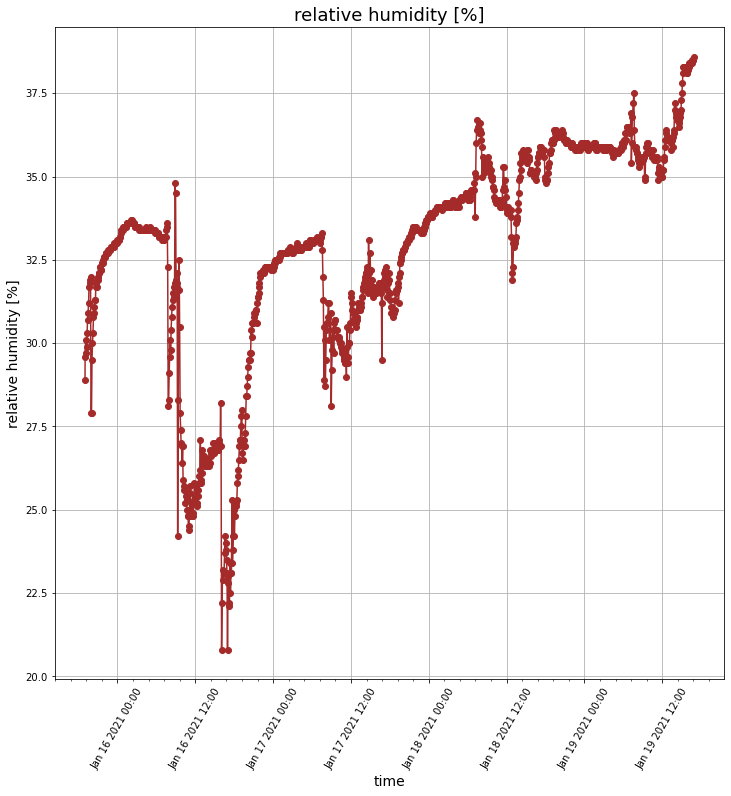

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
fig, ax = plt.subplots(figsize=(12, 12))
plt.xticks(rotation=60)
ax.xaxis.set_major_formatter(DateFormatter('%b %d %Y %H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.plot_date(df['Datum'], df['relative_humidity'], linestyle='solid', color='brown')         
plt.title('relative humidity [%]', fontsize=18)
plt.xlabel('time', fontsize=14)
plt.ylabel('relative humidity [%]', fontsize=14)
plt.grid(True)
plt.show()

Print again the first 5 lines of the Pandas dataframe. Check if a column for the relative humidity has been added.

In [7]:
df.head()

,Datum,Mode,raw_gas_resistance,relative_humidity,temperature
0,2021-01-15 19:00:00.000,2,177160,28.9,24.6
3,2021-01-15 19:00:56.688,2,174900,29.6,24.6
6,2021-01-15 19:05:29.504,2,175280,30.1,24.6
9,2021-01-15 19:10:02.312,2,175860,29.7,24.6
12,2021-01-15 19:14:35.120,2,173780,29.9,24.6


Create a subset of the measurement data: 'raw_gas_resistance','temperature','relative_humidity'

In [8]:
my_observations = df[['raw_gas_resistance','temperature','relative_humidity']] 
my_observations.head()

,raw_gas_resistance,temperature,relative_humidity
0,177160,24.6,28.9
3,174900,24.6,29.6
6,175280,24.6,30.1
9,175860,24.6,29.7
12,173780,24.6,29.9


Create a numpy array of measurements for further processing

In [9]:
list_of_rows = [list(row) for row in my_observations.values]

Print the first four elements of list of lists i.e. rows

In [10]:
print(list_of_rows[:4])

[[177160.0, 24.6, 28.9], [174900.0, 24.6, 29.6], [175280.0, 24.6, 30.1], [175860.0, 24.6, 29.7]]


Convert the selection of measurements to a numpy array

In [11]:
np.array(list_of_rows)
measurements = np.array(list_of_rows)
print("number of measurement datapoints = ", len(measurements))

number of measurement datapoints =  1226


In [12]:
F = np.eye(3)
H = np.array([ [1, 1, 1] ]).reshape(1, 3)
# key ist to set Q to a zero matrix, in this case the Kalman filter works as an ordinary least squares minimizer filter
Q = np.array([ [0, 0, 0], [0, 0, 0], [0, 0, 0] ]).reshape(3, 3)
# set covariance of gas resistance measurements also to a very small value
R = np.array([ [0.000000001] ]).reshape(1, 1)

print("\nF = ",F)  # the state-transition model;
print("\nInitial H = ",H)  # the observation model;
print("\nQ = ",Q)  # covariance of the process noise
print("\nR = ",R)  # covariance of the observation noise



F =  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Initial H =  [[1 1 1]]

Q =  [[0 0 0]
 [0 0 0]
 [0 0 0]]

R =  [[1.e-09]]


## Initialize the Kalman filter

In [13]:
kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
predictions = []
compensated_gas_resistance=[]
states=[]

#print("raw gas resistance measurements =", measurements[:,0])

print("dim measurements : ", measurements.shape)

last_index = len(measurements)

print ("last index of measurement array = ", last_index)



dim measurements :  (1226, 3)
last index of measurement array =  1226


## Run the Kalman filter

In [14]:
it = 0  # iteration index
#print("\nState vector kf.x= ", kf.x)
for z in measurements:
    zg = z[0] # raw_gas_resistance
    # make observation model matrix state dependant
    H = np.array([[1, z[1], z[2]]]).reshape(1, 3)
    # z[1]: measured temperature T
    # z[2]: measured relative humidity rH
    # estimated state vector x:
    # x[0]: estimated VOC resistance
    # x[1]: estimated regression coefficient for T temperature dependency
    # x[2]: estimated regression coefficient for rH relative humidity dependency
    kf.H = H
    it = it + 1
    #print("\nState vector kf.x= ", kf.x)
    #print results for the last sample of the measurement sequence
    if ((it == last_index)):  # print results of last measurement index 
        print ("\nIteration index = ", it)
        print ("\n")
        print("\nState vector kf.x= ", kf.x)
        print("\nObservation vector z = ", z)
        print("\nObservation transition matrix kf.H = ", kf.H)
        print("\nKalman filter prediction = ", kf.predict())
        print("\nKalman filter update = ",np.dot(H,  kf.predict()))
        print ("\n\n")
    predictions.append(np.dot(H,  kf.predict()))
   
    compensated_gas_resistance.append(zg-kf.predict()[1,0]*z[1]-kf.predict()[2,0]*z[2])
    print("\nraw gas resistance                = ",zg)
    print("\ntemperature coefficent prediction = ",kf.predict()[1,0])
    print("\ntemperature                       = ",z[1])
    print("\ntemperature compensation          = ",-kf.predict()[1,0]*z[1])
    print("\nhumidity coefficent prediction    = ",kf.predict()[2,0])
    print("\relative humidity                 = ",z[2])
    print("\nhumidity compensation             = ",-kf.predict()[2,0]*z[2])
    #print("\nKalman state prediction          = ",kf.predict())
    #print("\ntmperature coefficent prediction = ",kf.predict()[1,0])
    #print("\ncompensated gas resistance       = ",zg-kf.predict()[1,0]*z[1]-kf.predict()[2,0]*z[2])
    states.append(kf.x)
    kf.update(zg)  #only zg raw_gas_resistance is an observation variable!


raw gas resistance                =  177160.0

temperature coefficent prediction =  0.0

temperature                       =  24.6

temperature compensation          =  -0.0

humidity coefficent prediction    =  0.0
elative humidity                 =  28.9

humidity compensation             =  -0.0

raw gas resistance                =  174900.0

temperature coefficent prediction =  3023.6067075053434

temperature                       =  24.6

temperature compensation          =  -74380.72500463144

humidity coefficent prediction    =  3552.1233271099354
elative humidity                 =  29.6

humidity compensation             =  -105142.85048245409

raw gas resistance                =  175280.0

temperature coefficent prediction =  10976.403133842912

temperature                       =  24.6

temperature compensation          =  -270019.5170925357

humidity coefficent prediction    =  -3228.571362123147
elative humidity                 =  30.1

humidity compensation             = 

raw gas resistance                =  141680.0

temperature coefficent prediction =  3225.5158823204397

temperature                       =  24.6

temperature compensation          =  -79347.69070508282

humidity coefficent prediction    =  -22487.89785090043
elative humidity                 =  31.9

humidity compensation             =  717363.9414437237

raw gas resistance                =  141100.0

temperature coefficent prediction =  3632.6997429315843

temperature                       =  24.8

temperature compensation          =  -90090.9536247033

humidity coefficent prediction    =  -22567.491850552455
elative humidity                 =  32.1

humidity compensation             =  724416.4884027338

raw gas resistance                =  156880.0

temperature coefficent prediction =  4330.817757264784

temperature                       =  23.7

temperature compensation          =  -102640.38084717537

humidity coefficent prediction    =  -22643.647052205484
elative humidity       


raw gas resistance                =  188980.0

temperature coefficent prediction =  -13623.128211882806

temperature                       =  27.8

temperature compensation          =  378722.964290342

humidity coefficent prediction    =  -19194.543713499916
elative humidity                 =  25.7

humidity compensation             =  493299.77343694784

raw gas resistance                =  190300.0

temperature coefficent prediction =  -13564.923463094114

temperature                       =  27.5

temperature compensation          =  373035.39523508813

humidity coefficent prediction    =  -19218.886305950018
elative humidity                 =  25.5

humidity compensation             =  490081.60080172546

raw gas resistance                =  193340.0

temperature coefficent prediction =  -13564.529710262745

temperature                       =  27.6

temperature compensation          =  374381.0200032518

humidity coefficent prediction    =  -19219.0998134904
elative humidity    

humidity coefficent prediction    =  -19526.796430457245
elative humidity                 =  26.4

humidity compensation             =  515507.42576407123

raw gas resistance                =  181780.0

temperature coefficent prediction =  -12463.26893186464

temperature                       =  27.8

temperature compensation          =  346478.876305837

humidity coefficent prediction    =  -19531.588821493977
elative humidity                 =  26.3

humidity compensation             =  513680.7860052916

raw gas resistance                =  181440.0

temperature coefficent prediction =  -12443.914541683089

temperature                       =  27.8

temperature compensation          =  345940.8242587899

humidity coefficent prediction    =  -19534.757968378704
elative humidity                 =  26.4

humidity compensation             =  515717.61036519776

raw gas resistance                =  180900.0

temperature coefficent prediction =  -12418.356649061026

temperature           


raw gas resistance                =  88640.0

temperature coefficent prediction =  -9189.426184183758

temperature                       =  24.0

temperature compensation          =  220546.2284204102

humidity coefficent prediction    =  -15256.490071506283
elative humidity                 =  32.8

humidity compensation             =  500412.874345406

raw gas resistance                =  88740.0

temperature coefficent prediction =  -9185.150151933183

temperature                       =  24.0

temperature compensation          =  220443.6036463964

humidity coefficent prediction    =  -15261.052751830652
elative humidity                 =  32.8

humidity compensation             =  500562.5302600453

raw gas resistance                =  88360.0

temperature coefficent prediction =  -9180.941116758737

temperature                       =  24.0

temperature compensation          =  220342.58680220967

humidity coefficent prediction    =  -15265.543943863275
elative humidity          

humidity coefficent prediction    =  -15500.132624030335
elative humidity                 =  33.1

humidity compensation             =  513054.3898554041

raw gas resistance                =  70540.0

temperature coefficent prediction =  -9037.242329750638

temperature                       =  24.0

temperature compensation          =  216893.8159140153

humidity coefficent prediction    =  -15511.206378269848
elative humidity                 =  33.1

humidity compensation             =  513420.931120732

raw gas resistance                =  71640.0

temperature coefficent prediction =  -9033.599217872441

temperature                       =  24.0

temperature compensation          =  216806.38122893858

humidity coefficent prediction    =  -15521.722406236871
elative humidity                 =  33.1

humidity compensation             =  513769.0116464405

raw gas resistance                =  71380.0

temperature coefficent prediction =  -9030.153565369908

temperature                 

humidity coefficent prediction    =  -15608.968640428197
elative humidity                 =  30.8

humidity compensation             =  480756.23412518844

raw gas resistance                =  177340.0

temperature coefficent prediction =  -8979.670274185719

temperature                       =  23.1

temperature compensation          =  207430.38333369012

humidity coefficent prediction    =  -15644.323148988593
elative humidity                 =  31.2

humidity compensation             =  488102.8822484441

raw gas resistance                =  176240.0

temperature coefficent prediction =  -9090.844620009198

temperature                       =  23.2

temperature compensation          =  210907.5951842134

humidity coefficent prediction    =  -15675.405921357313
elative humidity                 =  31.2

humidity compensation             =  489072.66474634816

raw gas resistance                =  176720.0

temperature coefficent prediction =  -9193.333891672442

temperature           


raw gas resistance                =  90540.0

temperature coefficent prediction =  -11988.236721295114

temperature                       =  24.1

temperature compensation          =  288916.5049832123

humidity coefficent prediction    =  -16196.30299849023
elative humidity                 =  34.0

humidity compensation             =  550674.3019486679

raw gas resistance                =  89340.0

temperature coefficent prediction =  -11986.897165087143

temperature                       =  24.1

temperature compensation          =  288884.2216786002

humidity coefficent prediction    =  -16194.359330378069
elative humidity                 =  34.0

humidity compensation             =  550608.2172328543

raw gas resistance                =  88220.0

temperature coefficent prediction =  -11986.113257960522

temperature                       =  24.1

temperature compensation          =  288865.3295168486

humidity coefficent prediction    =  -16193.221897491088
elative humidity        

humidity coefficent prediction    =  -16134.227507973208
elative humidity                 =  34.2

humidity compensation             =  551790.5807726837

raw gas resistance                =  89500.0

temperature coefficent prediction =  -11944.502059713303

temperature                       =  24.0

temperature compensation          =  286668.04943311925

humidity coefficent prediction    =  -16131.82107788979
elative humidity                 =  34.3

humidity compensation             =  553321.4629716198

raw gas resistance                =  89940.0

temperature coefficent prediction =  -11942.372824165994

temperature                       =  24.1

temperature compensation          =  287811.1850624005

humidity coefficent prediction    =  -16128.448882132949
elative humidity                 =  34.3

humidity compensation             =  553205.79665716

raw gas resistance                =  90680.0

temperature coefficent prediction =  -11938.772901004504

temperature                


raw gas resistance                =  89940.0

temperature coefficent prediction =  -11891.398353432287

temperature                       =  24.0

temperature compensation          =  285393.56048237486

humidity coefficent prediction    =  -16050.712274427417
elative humidity                 =  34.4

humidity compensation             =  552144.5022403031

raw gas resistance                =  90480.0

temperature coefficent prediction =  -11888.540333988705

temperature                       =  24.0

temperature compensation          =  285324.9680157289

humidity coefficent prediction    =  -16046.399768047133
elative humidity                 =  34.4

humidity compensation             =  551996.1520208213

raw gas resistance                =  90860.0

temperature coefficent prediction =  -11885.47606911154

temperature                       =  24.0

temperature compensation          =  285251.425658677

humidity coefficent prediction    =  -16041.776054984815
elative humidity        

raw gas resistance                =  98300.0

temperature coefficent prediction =  -5288.7926684057065

temperature                       =  24.5

temperature compensation          =  129575.42037593981

humidity coefficent prediction    =  -8908.272221643656
elative humidity                 =  35.9

humidity compensation             =  319806.9727570072

raw gas resistance                =  99600.0

temperature coefficent prediction =  -5287.70940700865

temperature                       =  24.5

temperature compensation          =  129548.88047171192

humidity coefficent prediction    =  -8907.481649889874
elative humidity                 =  35.9

humidity compensation             =  319778.5912310465

raw gas resistance                =  100140.0

temperature coefficent prediction =  -5285.535824746684

temperature                       =  24.5

temperature compensation          =  129495.62770629376

humidity coefficent prediction    =  -8905.895354333235
elative humidity          


humidity compensation             =  319056.8219213091

raw gas resistance                =  97680.0

temperature coefficent prediction =  -5294.818519319981

temperature                       =  24.4

temperature compensation          =  129193.57187140752

humidity coefficent prediction    =  -8912.972605732144
elative humidity                 =  35.9

humidity compensation             =  319975.716545784

raw gas resistance                =  97820.0

temperature coefficent prediction =  -5294.713369679323

temperature                       =  24.4

temperature compensation          =  129191.00622017546

humidity coefficent prediction    =  -8912.88894532912
elative humidity                 =  35.9

humidity compensation             =  319972.71313731535

raw gas resistance                =  98180.0

temperature coefficent prediction =  -5294.513804552496

temperature                       =  24.3

temperature compensation          =  128656.68545062566

humidity coefficent predict

elative humidity                 =  35.9

humidity compensation             =  318539.4041296753

raw gas resistance                =  94000.0

temperature coefficent prediction =  -5251.637932584744

temperature                       =  24.3

temperature compensation          =  127614.80176180927

humidity coefficent prediction    =  -8874.657872089036
elative humidity                 =  35.8

humidity compensation             =  317712.75182078744

raw gas resistance                =  93900.0

temperature coefficent prediction =  -5254.229248213662

temperature                       =  24.3

temperature compensation          =  127677.77073159198

humidity coefficent prediction    =  -8876.967665397642
elative humidity                 =  35.8

humidity compensation             =  317795.44242123555

raw gas resistance                =  93980.0

temperature coefficent prediction =  -5256.858482311013

temperature                       =  24.3

temperature compensation          =  127

## Plot the results of the Kalman filter

### Plot measured gas resistance versus corrected gas resistance (compensation of temperature and humidity interference)

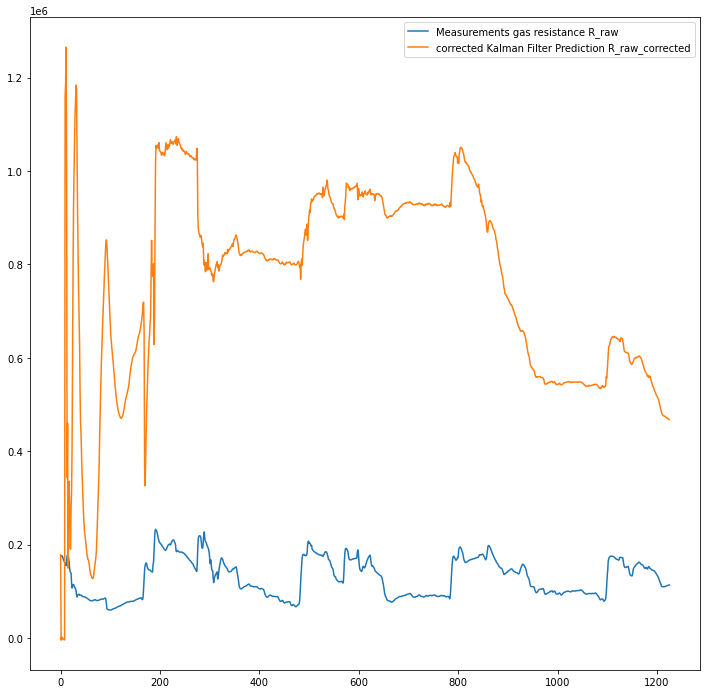

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(range(len(measurements)), measurements[:,0], label = 'Measurements gas resistance R_raw')
ax.plot(range(len(predictions)), compensated_gas_resistance[:], label = 'corrected Kalman Filter Prediction R_raw_corrected')
ax.legend()
plt.show()

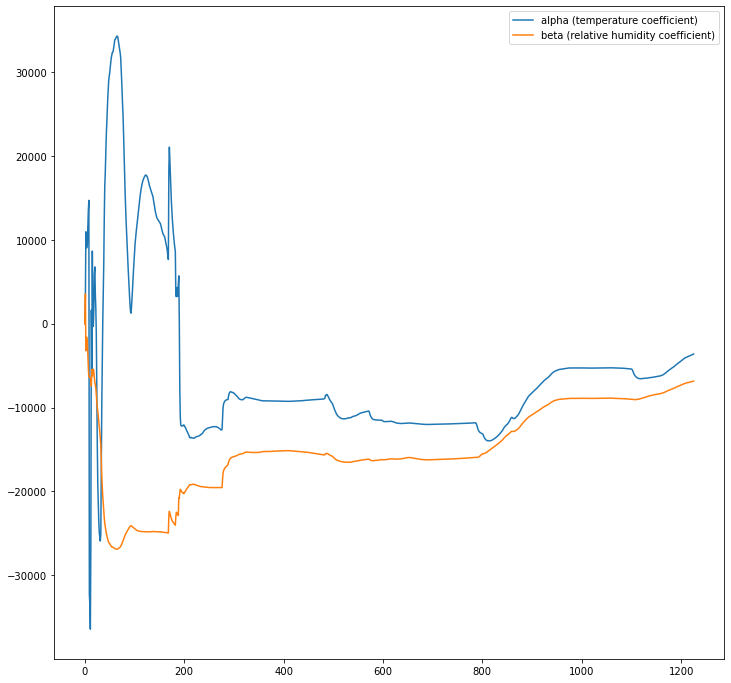

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(range(len(predictions)), np.array(states)[:,1], label = 'alpha (temperature coefficient)')
ax.plot(range(len(predictions)), np.array(states)[:,2], label = 'beta (relative humidity coefficient)')
ax.legend()
plt.show()

# Regression results of the recursive minimum least-square error (LMMSE) Kalman filter

In [17]:
print("\nNumber of captured data points used for online regression using Kalman filter  = %11d" % len(measurements))

print("\n\nLinear regression coefficient of temperature interference alpha_LMMSE          = %11.3lf" % kf.predict()[1][0])
print("Linear regression coefficient of relative humidity interference beta_LMMSE     = %11.3lf" % kf.predict()[2][0])
print("\n\n")


Number of captured data points used for online regression using Kalman filter  =        1226


Linear regression coefficient of temperature interference alpha_LMMSE          =   -3580.083
Linear regression coefficient of relative humidity interference beta_LMMSE     =   -6835.842





# You are done! Congratulations!